In [31]:
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
from sklearn.linear_model import SGDClassifier
import random
import shutil
from PIL import Image
import matplotlib.pyplot as plt

import requests


# Gathering the data

For using the TCAV, in addition to our dataset on which our model is trained, we need three other sets:
- The concept set: contains 30 to 100 images that will be used to fit our concept activation vector
- The random set: contains roughly the same amount of image as the concept set, these are the random images that will be use to train the linear classifier from which we will infer the CAV 
- The target set: contains the images that we wish to evaluate our concept on

In [ ]:
concept_image_paths = "data_tcav/concepts/wheel/*.jpg"
random_image_paths = "data/concepts/random/*.jpg"
target_image_paths = "data/targets/car/*.jpg"

In [32]:
def preview_image(image_path):
    image_files = [f for f in os.listdir(image_path) if f.endswith('.jpg')]

    # Limit to first 40 images
    image_files = image_files[:40]

    # Set up a grid size (e.g., 5x8 grid for 40 images)
    fig, axes = plt.subplots(nrows=5, ncols=8, figsize=(15, 10))

    # Loop through images and plot them
    for i, ax in enumerate(axes.flat):
        if i < len(image_files):
            img_path = os.path.join(image_path, image_files[i])
            img = Image.open(img_path)
            ax.imshow(img)
            ax.axis('off')  # Hide axes

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

## Random images

Failed to download image 0 from https://source.unsplash.com/random/400x400?sig=0
Failed to download image 1 from https://source.unsplash.com/random/400x400?sig=1
Failed to download image 2 from https://source.unsplash.com/random/400x400?sig=2
Failed to download image 3 from https://source.unsplash.com/random/400x400?sig=3
Failed to download image 4 from https://source.unsplash.com/random/400x400?sig=4
Failed to download image 5 from https://source.unsplash.com/random/400x400?sig=5
Failed to download image 6 from https://source.unsplash.com/random/400x400?sig=6
Failed to download image 7 from https://source.unsplash.com/random/400x400?sig=7
Failed to download image 8 from https://source.unsplash.com/random/400x400?sig=8
Failed to download image 9 from https://source.unsplash.com/random/400x400?sig=9
Failed to download image 10 from https://source.unsplash.com/random/400x400?sig=10
Failed to download image 11 from https://source.unsplash.com/random/400x400?sig=11
Failed to download image

UnidentifiedImageError: cannot identify image file 'data_tcav/random/img_0.jpg'

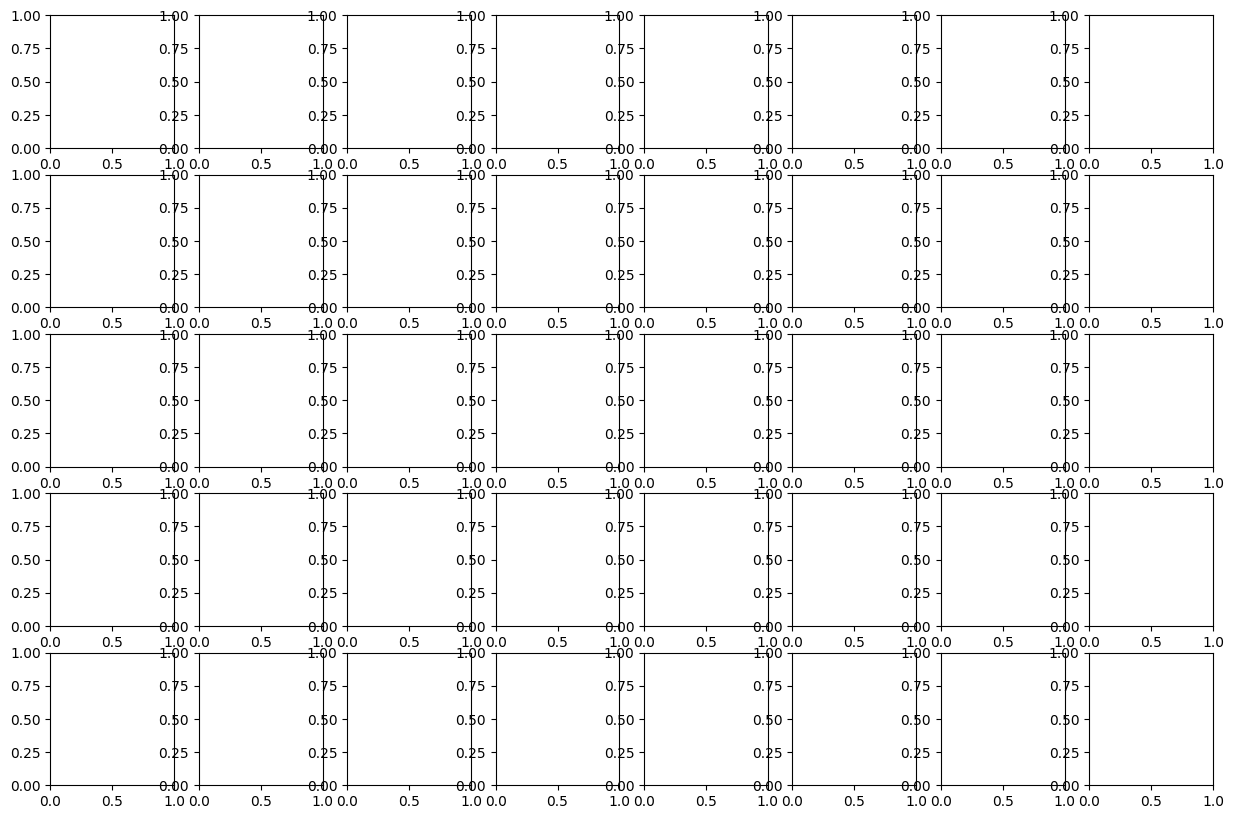

In [36]:

for i in range(40):
    url = f"https://source.unsplash.com/random/400x400?sig={i}"
    response = requests.get(url)
    
    # Check if the download was successful
    if response.status_code == 200:
        with open(f"data_tcav/random/img_{i}.jpg", 'wb') as f:
            f.write(response.content)
    else:
        print(f"Failed to download image {i} from {url}")


        
preview_image("data_tcav/random")

## Target images

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("prondeau/the-car-connection-picture-dataset")
destination_dir = "/path/to/your/target/directory"

print("Path to dataset files:", path)

Resuming download from 627048448 bytes (88274118 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/prondeau/the-car-connection-picture-dataset?dataset_version_number=1 (627048448/715322566) bytes left.


100%|██████████| 682M/682M [00:03<00:00, 24.5MB/s]

Extracting files...


Path to dataset files: /home/raph2268/.cache/kagglehub/datasets/prondeau/the-car-connection-picture-dataset/versions/1


In [ ]:
all_files = os.listdir(path)
print(len(all_files))

64467


In [ ]:
destination_dir = 'data_tcav/targets/car'

# Randomly select 300 files to keep (or however many are available)
num_files_to_keep = 300
files_to_keep = random.sample(all_files, min(num_files_to_keep, len(all_files)))

# Loop through the files and move or delete them
for file_name in all_files:
    file_path = os.path.join(path, file_name)
    
    if file_name in files_to_keep:
        # Move the selected file to the destination directory
        shutil.move(file_path, os.path.join(destination_dir, file_name))
    else:
        # Remove the files you don't want
        os.remove(file_path)

print("300 randomly selected files moved, and the rest removed.")

300 randomly selected files moved, and the rest removed.


In [ ]:
model = models.resnet50(pretrained=True)
model.eval()

# Choose a layer (we'll hook 'layer4' as an example)
layer_activations = []

def hook(module, input, output):
    layer_activations.append(output.detach())

hook_handle = model.layer4.register_forward_hook(hook)

/home/raph2268/anaconda3/envs/XAI/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/raph2268/anaconda3/envs/XAI/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/raph2268/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100.0%


In [ ]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def load_image(path):
    img = Image.open(path).convert('RGB')
    return preprocess(img).unsqueeze(0)# shape: [1, 3, 224, 224]

In [ ]:
def get_activations(img_paths):
    activations = []
    for path in img_paths:
        layer_activations.clear()
        input_tensor = load_image(path)
        _ = model(input_tensor)
        acts = layer_activations[0]
        acts = acts.mean(dim=(2, 3)).squeeze().numpy()  # Global Average Pool
        activations.append(acts)
    return np.array(activations)


In [ ]:

concept_activations = get_activations(concept_image_paths)
random_activations = get_activations(random_image_paths)

X = np.concatenate([concept_activations, random_activations])
y = np.array([1] * len(concept_activations) + [0] * len(random_activations))

clf = SGDClassifier(alpha=0.01, max_iter=1000)
clf.fit(X, y)
cav = clf.coef_[0]